In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload

In [2]:
from fastai.vision import *
import pandas as pd
import numpy as np

In [3]:
# get_category_names
with open('/home/app/ml/grager/anno/list_category_cloth.txt', 'r') as f:
    categories = []
    for i, line in enumerate(f.readlines()):
        if i > 1:
            categories.append(line.split(' ')[0])

In [4]:
# get image category map
with open('/home/app/ml/grager/anno/list_category_img.txt', 'r') as f:
    images = []
    for i, line in enumerate(f.readlines()):
        if i > 1:
            images.append([word.strip() for word in line.split(' ') if len(word) > 0])

In [5]:
#get train, valid, test split
with open('/home/app/ml/grager/eval/list_eval_partition.txt', 'r') as f:
    images_partition = []
    for i, line in enumerate(f.readlines()):
        if i > 1:
            images_partition.append([word.strip() for word in line.split(' ') if len(word) > 0])

In [8]:
#check images list
images

[['img/279-티셔츠/cap_5e24dfb95ebd0.png', '4'],
 ['img/279-티셔츠/cap_5e4091bd4a2f3.png', '4'],
 ['img/279-티셔츠/cap_5e316f14e59ac.png', '4'],
 ['img/279-티셔츠/cap_5dfc8a708e120.png', '4'],
 ['img/279-티셔츠/cap_5e1ec15929972.png', '4'],
 ['img/279-티셔츠/cap_5e001f1544013.png', '4'],
 ['img/279-티셔츠/cap_5e1eb9ef2f007.png', '4'],
 ['img/279-티셔츠/cap_5dfc1c9e6a8b9.png', '4'],
 ['img/279-티셔츠/cap_5e5e798c5c6fe.png', '4'],
 ['img/279-티셔츠/cap_5e128b4f2e1fe.png', '4'],
 ['img/279-티셔츠/cap_5e0e9bda9f220.png', '4'],
 ['img/279-티셔츠/cap_5e4e3ad804c0b.png', '4'],
 ['img/279-티셔츠/cap_5e0da0feb1a11.png', '4'],
 ['img/279-티셔츠/cap_5e33ef41f3bf9.png', '4'],
 ['img/279-티셔츠/cap_5e1831940dc38.png', '4'],
 ['img/279-티셔츠/cap_5e129adc004cb.png', '4'],
 ['img/279-티셔츠/cap_5e16e8be867ed.png', '4'],
 ['img/279-티셔츠/cap_5e45db957bfb1.png', '4'],
 ['img/279-티셔츠/cap_5e1d70c20ba69.png', '4'],
 ['img/279-티셔츠/cap_5e0964003be26.png', '4'],
 ['img/279-티셔츠/cap_5e3bcf785550a.png', '4'],
 ['img/279-티셔츠/cap_5e6f7aeedff1e.png', '4'],
 ['img/279

In [9]:
data_df = pd.DataFrame(images, columns=['images', 'category_label'])
partition_df = pd.DataFrame(images_partition, columns=['images', 'dataset'])

In [10]:
data_df['category_label'] = data_df['category_label'].astype(int)

In [11]:
data_df = data_df.merge(partition_df, on='images')

In [12]:
data_df['category'] = data_df['category_label'].apply(lambda x: categories[int(x) - 1])

In [13]:
data_df['category_label'].nunique()

7

In [14]:
from pathlib import Path
images_path = Path('/home/app/ml/grager/')

In [15]:
data_source = (ImageList.from_df(df=data_df, path=images_path, cols='images')
                    .split_by_idxs((data_df[data_df['dataset']=='train'].index), (data_df[data_df['dataset']=='val'].index))
                    .label_from_df(cols='category')
              )

In [16]:
tmfs = get_transforms()

data = data_source.transform(tmfs, size=224).databunch(bs=16*2**3).normalize(imagenet_stats)

In [17]:
test_data = ImageList.from_df(df=data_df[data_df['dataset'] == 'test'], path=images_path, cols='images')
data.add_test(test_data)

In [18]:
from fastai.metrics import accuracy, top_k_accuracy

top_3_accuracy = partial(top_k_accuracy, k=3)
top_5_accuracy = partial(top_k_accuracy, k=5)


In [19]:
learner = cnn_learner(data,models.resnet152,metrics=accuracy)

In [21]:
#loadl model
learner.load('g-resnet50-224-freezed')

Learner(data=ImageDataBunch;

Train: LabelList (25450 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
티셔츠,티셔츠,티셔츠,티셔츠,티셔츠
Path: /home/app/ml/grager;

Valid: LabelList (8483 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
티셔츠,티셔츠,티셔츠,티셔츠,티셔츠
Path: /home/app/ml/grager;

Test: LabelList (8482 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /home/app/ml/grager, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottlen

In [22]:
#using 3 gpus
learner.model = torch.nn.DataParallel(learner.model,device_ids=[0,1,2])
model = learner.model.module

In [23]:
class Hook():
    "Create a hook on `m` with `hook_func`."
    def __init__(self, m:nn.Module, hook_func:HookFunc, is_forward:bool=True, detach:bool=True):
        self.hook_func,self.detach,self.stored = hook_func,detach,None
        f = m.register_forward_hook if is_forward else m.register_backward_hook
        self.hook = f(self.hook_fn)
        self.removed = False

    def hook_fn(self, module:nn.Module, input:Tensors, output:Tensors):
        "Applies `hook_func` to `module`, `input`, `output`."
        if self.detach:
            input  = (o.detach() for o in input ) if is_listy(input ) else input.detach()
            output = (o.detach() for o in output) if is_listy(output) else output.detach()
        self.stored = self.hook_func(module, input, output)

    def remove(self):
        "Remove the hook from the model."
        if not self.removed:
            self.hook.remove()
            self.removed=True

    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()
        
def get_output(module, input_value, output):
    return output.flatten(1)

def get_input(module, input_value, output):
    return list(input_value)[0]

def get_named_module_from_model(model, name):
    for n, m in model.named_modules():
        if n == name:
            return m
    return None

In [24]:
linear_output_layer = get_named_module_from_model(model, '1.4')
linear_output_layer

Linear(in_features=4096, out_features=512, bias=True)

In [25]:
# getting all images in train
train_valid_images_df = data_df[data_df['dataset'] != 'test']
inference_data_source = (ImageList.from_df(df=train_valid_images_df, path=images_path, cols='images')
                    .split_none()
                    .label_from_df(cols='category')
              )

In [26]:
inference_data = inference_data_source.transform(tmfs, size=224).databunch(bs=16*2**0).normalize(imagenet_stats)

In [27]:
inference_dataloader = inference_data.train_dl.new(shuffle=False)

In [28]:
import time
img_repr_map = {}

with Hook(linear_output_layer, get_output, True, True) as hook:
    start = time.time()
    for i, (xb, yb) in enumerate(inference_dataloader):
        bs = xb.shape[0]
        img_ids = inference_dataloader.items[i*bs: (i+1)*bs]
        result = model.eval()(xb)
        img_reprs = hook.stored.cpu().numpy()
        img_reprs = img_reprs.reshape(bs, -1)
        for img_id, img_repr in zip(img_ids, img_reprs):
            img_repr_map[img_id] = img_repr
        if(len(img_repr_map) % 12800 == 0):
            end = time.time()
            print(f'{end-start} secs for 12800 images')
            start = end

51.31495642662048 secs for 12800 images
49.57519817352295 secs for 12800 images


In [29]:
enumerate(inference_dataloader)

In [30]:
img_repr_df = pd.DataFrame(img_repr_map.items(), columns=['img_id', 'img_repr'])

In [31]:
img_repr_df.shape

(33920, 2)

In [33]:
img_repr_df['label'] = [inference_data.classes[x] for x in inference_data.train_ds.y.items[0:img_repr_df.shape[0]]]

In [34]:
img_repr_df['label_id'] = inference_data.train_ds.y.items[0:img_repr_df.shape[0]]

In [35]:
from scipy.spatial.distance import cosine

cnn_time = 0

def get_similar_images(img_index, cnn_time,n=20):
    start = time.time()
    base_img_id, base_vector, base_label  = img_repr_df.iloc[img_index, [0, 1, 2]]
    cosine_similarity = 1 - img_repr_df['img_repr'].apply(lambda x: cosine(x, base_vector))
    similar_img_ids = np.argsort(cosine_similarity)[-1*similar_max-1:-1][::-1]
    end = time.time()
    op_time = end - start
    print(f'{op_time} s')
    return base_img_id, base_label, img_repr_df.iloc[similar_img_ids],op_time

def show_similar_images(similar_images_df):
    similar_images_df.sort_values(by=['img_id'])
    images = [open_image(img_id) for img_id in similar_images_df['img_id']]
    ##save images
    #img = images[0]
    #rgb_im = img.convert('RGB')
    #rgb_im.save('colors.jpg')
    ###
    categories = [learner.data.train_ds.y.reconstruct(y) for y in similar_images_df['label_id']]
    return learner.data.show_xys(images, categories)
    #return learner.data.show_xys(images)

In [36]:
annoy_time = 0
def get_similar_images_annoy(img_index):
    start = time.time()
    base_img_id, base_vector, base_label  = img_repr_df.iloc[img_index, [0, 1, 2]]
    similar_img_ids = t.get_nns_by_item(img_index, similar_max+1)
    end = time.time()   
    op_time = end - start
    print(f'{op_time} s')    
    return base_img_id, base_label, img_repr_df.iloc[similar_img_ids[1:]],op_time

In [37]:
from annoy import AnnoyIndex

In [38]:
similar_max = 20
for i in range (1,501):
    search_image_index=i
    
    f = len(img_repr_df['img_repr'][0])
    t = AnnoyIndex(f, metric='euclidean')
    
    for i, vector in enumerate(img_repr_df['img_repr']):
        t.add_item(i, vector)
    _  = t.build(inference_data.c)
    
    #cnn
    base_image, base_label, similar_images_df,cnn_time = get_similar_images(search_image_index,similar_max)
    base_image_filename = base_image.split('/')[7]

In [46]:
    #make result file - skip 
    f = open('./result.txt','a')
    f.write("#squence\r\n")
    squence = "%d" % (search_image_index)
    f.write(squence)
    #result_txt = "%s %s" % (base_image_filename,cnn_time)
    f.write("\r\n#base_image\r\n")
    f.write(base_image_filename)
    f.write("\r\n")
    f.write("#cnn_time\r\n")
    f.write(str(cnn_time))
    f.write("\r\n#cnn_list")
    #f.write(result_txt)
    f.close()
    
    cnn_list = similar_images_df['img_id'].str.split('/').str[7].tolist()
    f = open('./result.txt','a')
    for each_item in cnn_list:
        result_txt = "\r\n%s" % (each_item)    
        f.write(result_txt)
    f.close()
    
    #annoy
    base_image, base_label, similar_images_df,annoy_time = get_similar_images_annoy(search_image_index)
    f = open('./result.txt','a')
    f.write("\r\n")
    f.write("#annoy_time\r\n")
    f.write(str(annoy_time))
    f.write("\r\n#annoy_list")
    #f.write(result_txt)
    f.close()
    
    annoy_list = similar_images_df['img_id'].str.split('/').str[7].tolist()
    f = open('./result.txt','a')
    for each_item in annoy_list:
        result_txt = "\r\n%s" % (each_item)    
        f.write(result_txt)
    f.write("\r\n\r\n\r\n\r\n")
    f.close()
    

0.0015435218811035156 s


In [42]:
# category sample
# 15 줄무늬
# 20 슬림핏
# 3333 오프숄더
# 15239 체크셔츠
# 18239 니트
# 20009 니트
# 29999 털스웨터
# 31230 나시
# 33001 맨투맨
search_image_index = 15
similar_max = 20

In [43]:
#making annoy index
f = len(img_repr_df['img_repr'][0])
t = AnnoyIndex(f, metric='euclidean')

In [44]:
for i, vector in enumerate(img_repr_df['img_repr']):
    t.add_item(i, vector)
_  = t.build(inference_data.c)

2.2232918739318848 s
cap_5e0964003be26.png


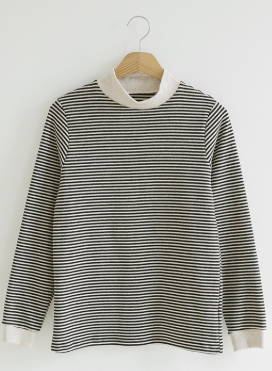

In [45]:
#without annoy
base_image, base_label, similar_images_df,cnn_time = get_similar_images(search_image_index,similar_max)
#print("without annoy")
#print(base_label)
base_image_filename = base_image.split('/')[7]
print(base_image_filename)
open_image(base_image)
#print(cnn_time)
# 베이스이미지 cnn_time 저장
#f = open('./result.txt','a')
#f.write("#squence\r\n")
#squence = "%d" % (search_image_index)
#f.write(squence)
#result_txt = "%s %s" % (base_image_filename,cnn_time)
#f.write("\r\n#base_image\r\n")
#f.write(base_image_filename)
#f.write("\r\n")
#f.write("#cnn_time\r\n")
#f.write(str(cnn_time))
#f.write("\r\n#cnn_list")
#f.write(result_txt)
#f.close()
# 베이스이미지 cnn_time 저장

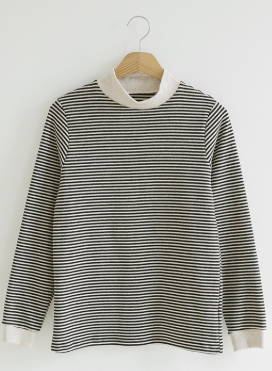

In [47]:
open_image(base_image)

/home/app/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 54980 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/app/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 46300 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/app/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 45768 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/app/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 53944 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/app/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 54000 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/app/anaconda3/envs/fastai/lib/pyth

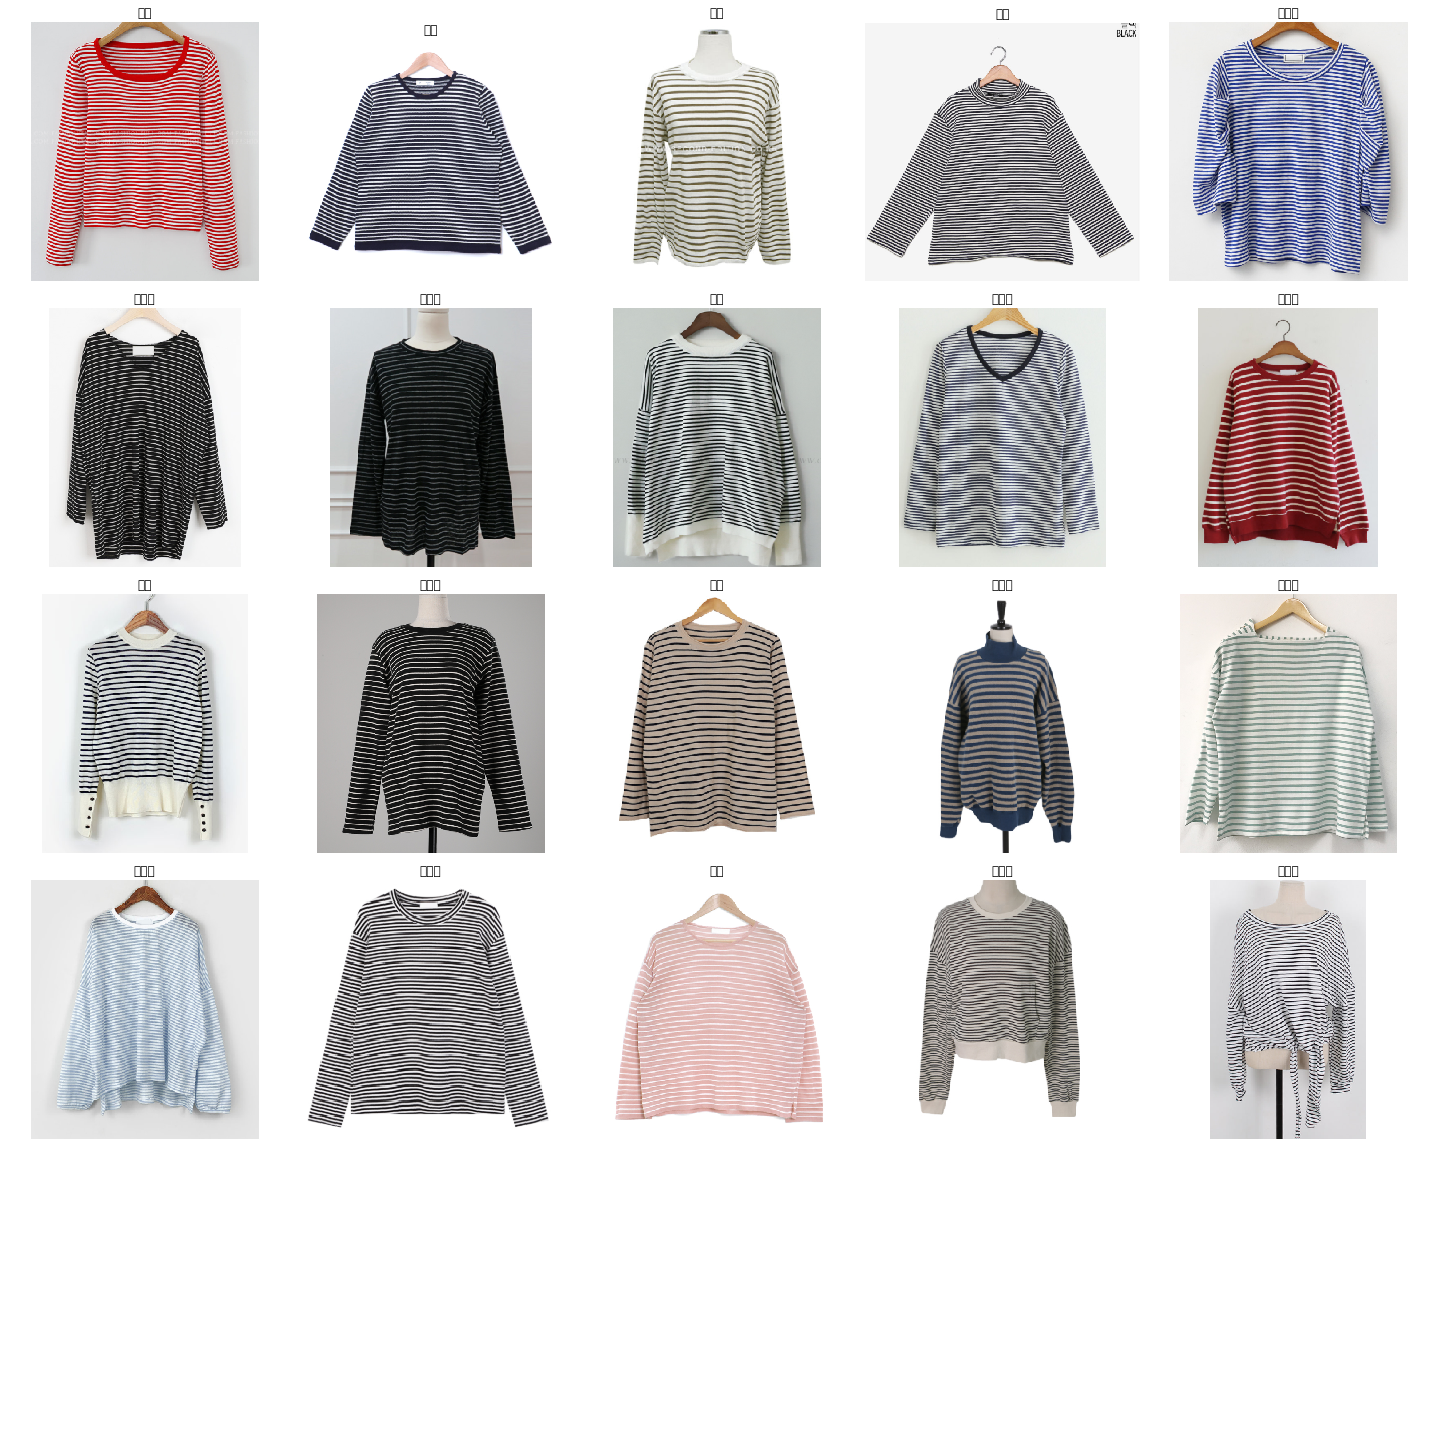

In [48]:
cnn_list = similar_images_df['img_id'].str.split('/').str[7].tolist()
f = open('./result.txt','a')
for each_item in cnn_list:
    result_txt = "\r\n%s" % (each_item)    
    f.write(result_txt)
f.close()

show_similar_images(similar_images_df)
#pd.set_option('display.max_colwidth', None)
#font problem

In [49]:
#img_repr_df

In [50]:
#with annoy
base_image, base_label, similar_images_df,annoy_time = get_similar_images_annoy(search_image_index)
#print(base_label)
print(base_image_filename)
# 베이스이미지 annoy_time 저장
f = open('./result.txt','a')
#result_txt = "%s %s" % (base_image_filename,cnn_time)
#f.write("#base_image\r\n")
#f.write(base_image_filename)
f.write("\r\n")
f.write("#annoy_time\r\n")
f.write(str(cnn_time))
f.write("\r\n#annoy_list")
f.write(result_txt)
f.close()
# 베이스이미지 annoy_time 저장

0.004664897918701172 s
cap_5e0964003be26.png


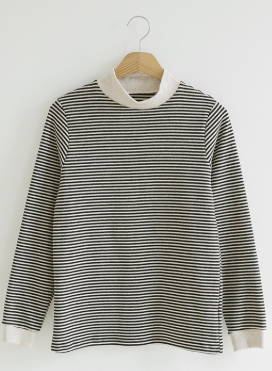

In [51]:
open_image(base_image)

/home/app/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 54980 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/app/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 46300 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/app/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 45768 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/app/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 53944 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/app/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 54000 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/app/anaconda3/envs/fastai/lib/pyth

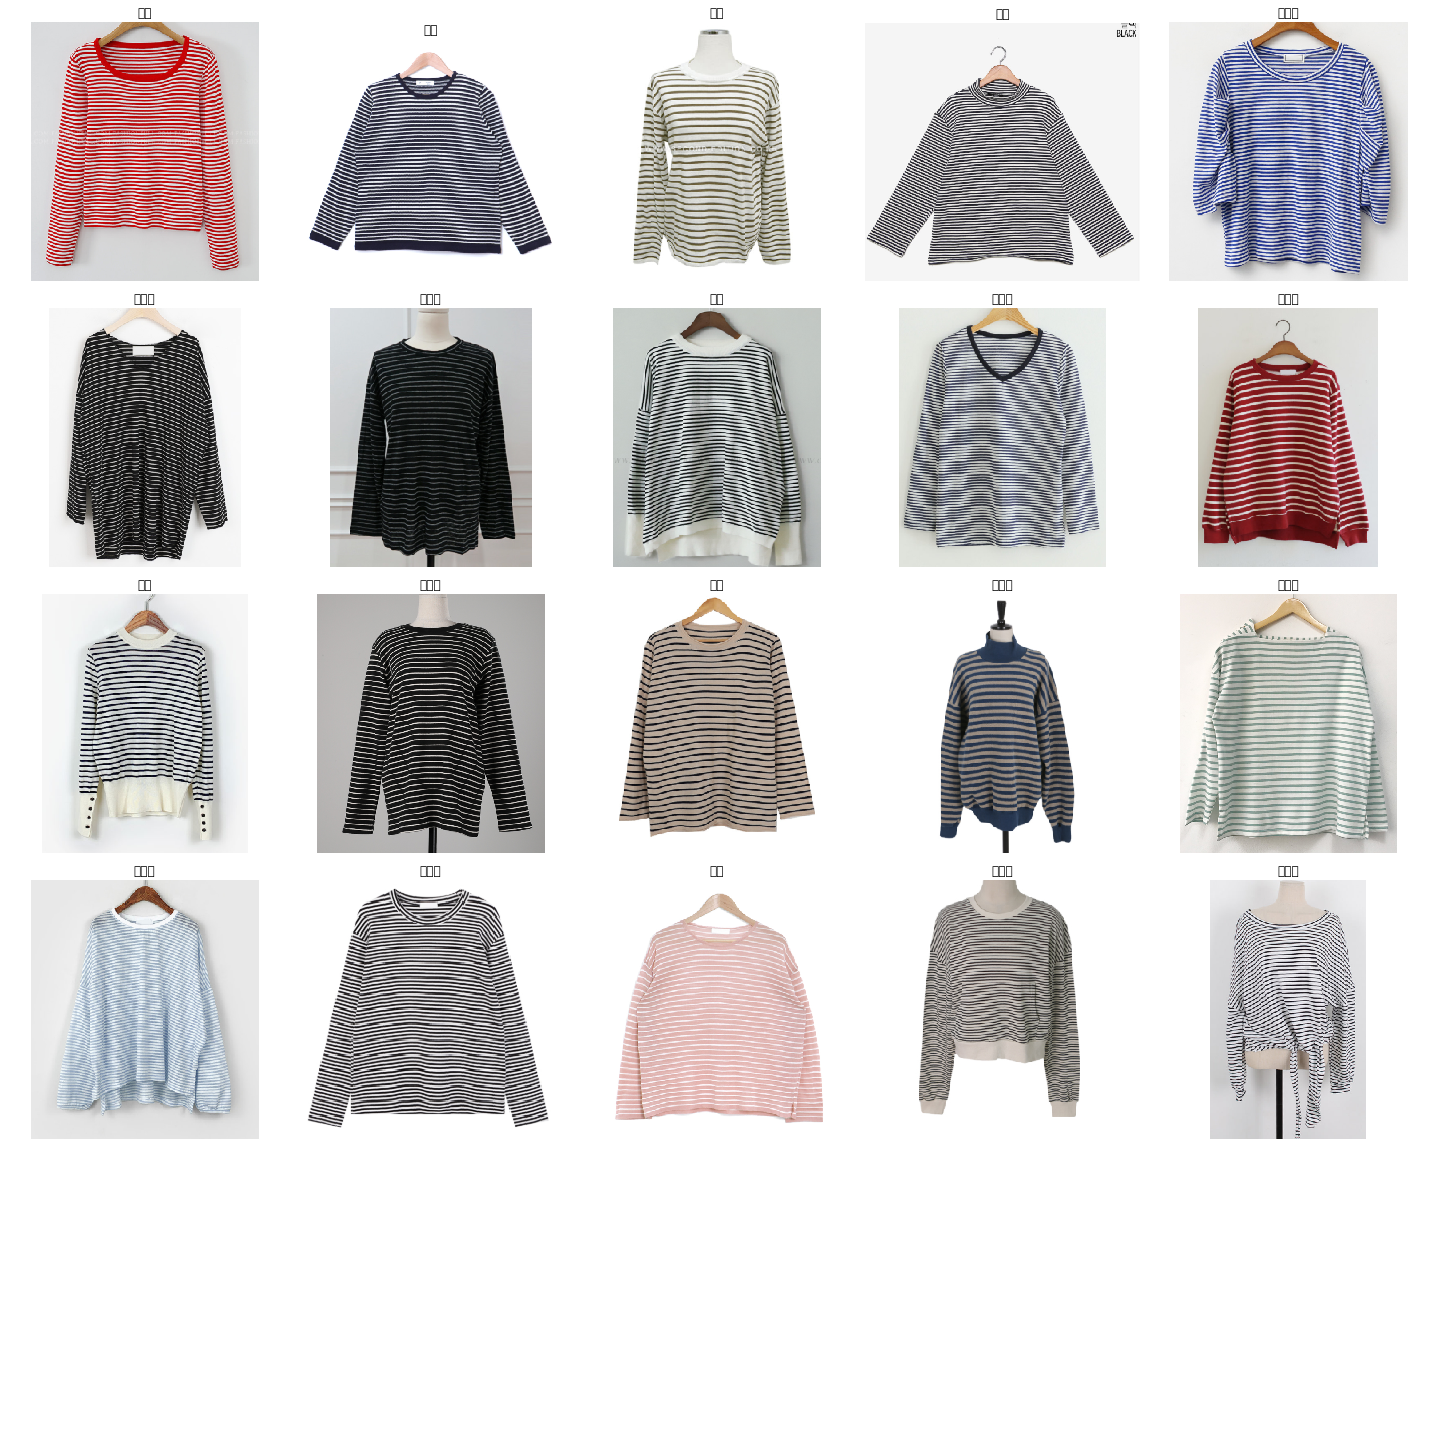

In [52]:
similar_images_df

annoy_list = similar_images_df['img_id'].str.split('/').str[7].tolist()
f = open('./result.txt','a')
for each_item in annoy_list:
    result_txt = "\r\n%s" % (each_item)    
    f.write(result_txt)
f.close()

show_similar_images(similar_images_df)
#print(base_image)
#pd.set_option('display.max_colwidth', None)
#print(similar_images_df['img_id'])